### V2 

### paper review:
Enviroment dataset: 8 soil variable + 72 weather variables.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from matplotlib.image import imread
import numpy as np
import seaborn as sns
import math
from math import sqrt
%matplotlib inline

ModuleNotFoundError: No module named 'tensorflow'

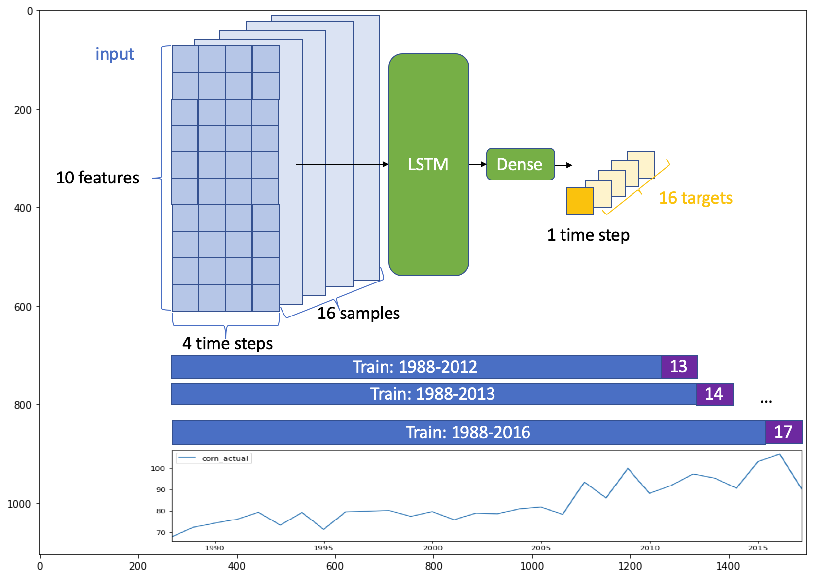

In [2]:
plt.figure(figsize = (20,10))
plt.imshow(imread('fig_2.png'))

In [141]:
df = pd.read_csv('initial_model_data_2017.csv')
df.head()

,document_year,corn_projected,corn_actual,soy_projected,soy_actual,Corn Price per bushel,Soy Price per bushel,avg_closing_price,year_open,year_high,year_low,year_close,annual_percent_change
0,1988,67.5,67.7,58.8,58.8,2.54,7.42,2.5460,1.8750,3.5350,1.8750,2.8450,0.5399
1,1989,72.3,72.2,60.5,60.8,2.36,5.69,2.5411,2.8075,2.8950,2.1725,2.3975,-0.1573
2,1990,74.5,74.2,57.7,57.8,2.28,5.74,2.5198,2.3775,2.9225,2.1875,2.3175,-0.0334
3,1991,75.9,76.0,59.8,59.2,2.37,5.58,2.4676,2.3175,2.6250,2.1950,2.5150,0.0852
4,1992,79.3,79.3,59.1,59.1,2.07,5.56,2.3936,2.5050,2.7875,2.0500,2.1650,-0.1392


### Visualization

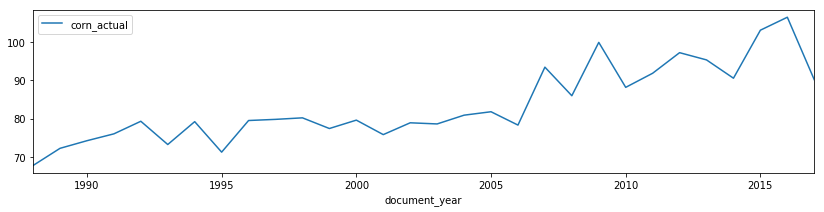

In [5]:
df.plot.line(x='document_year', y='corn_actual', figsize=(14,3))

### Base Line I :
#### MSE=49.3 (1989~2017)
#### MSE=82 (2012-2017)

In [5]:
from sklearn.metrics import mean_squared_error

df1 = df
df1['pred']=df1['corn_actual'].shift(periods=1) # creat predic test

In [21]:
df1['corn_actual'][24:]

24     97.3
25     95.4
26     90.6
27    103.2
28    106.6
29     90.2
Name: corn_actual, dtype: float64

In [6]:
mean_squared_error(df1['corn_actual'][24:], df1['pred'][24:])

82.51499999999997

### Base Line II: 
#### MAE=5.3, RMSE=7 (1989~2017)
#### MAE=7.4, RMSE=9 (2012~2017)

In [7]:
steps = len(df1['corn_actual'][1:])

def evaluate_naive_method():
    batch_maes = []
    batch_rmse = []
    for step in range(steps):
        targets = df1['corn_actual'][1:]
        preds = df1['pred'][1:]
        mae = np.mean(np.abs(preds - targets))
        rmse = np.sqrt(np.mean((preds - targets)**2))
        batch_maes.append(mae)
        batch_rmse.append(rmse)
    print(np.mean(batch_maes))
    print(np.mean(batch_rmse))
evaluate_naive_method()

5.389655172413793
7.025102772594663


In [92]:
steps = len(df1['corn_actual'][3:])
#targets = df1['corn_actual'][3:]
#preds = df1['pred'][3:]

def evaluate_naive_method(targets,preds):
    batch_maes = []
    batch_rmse = []
    for step in range(steps):
        mae = np.mean(np.abs(preds - targets))
        rmse = np.sqrt(np.mean((preds - targets)**2))
        batch_maes.append(mae)
        batch_rmse.append(rmse)
    print(np.mean(batch_maes))
    print(np.mean(batch_rmse))
#evaluate_naive_method(targets,preds)

## Data Processing

### 0. Feature selection (so far, select all)

In [3]:
titles = [
     'corn_projected',
    'corn_actual',
    'soy_projected',
    'soy_actual',
    'Corn Price per bushel',
    'Soy Price   per bushel',
    ' avg_closing_price',
    ' year_open',
    ' year_high',
    ' year_low',
    ' year_close',
    ' annual_percent_change',
]

feature_keys = [
     'corn_projected',
    'corn_actual',
    'soy_projected',
    'soy_actual',
    'Corn Price per bushel',
    'Soy Price   per bushel',
    ' avg_closing_price',
    ' year_open',
    ' year_high',
    ' year_low',
    ' year_close',
    ' annual_percent_change',
]

date_time_key = "document_year"

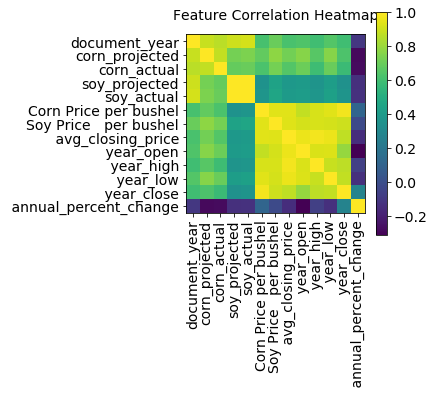

In [4]:
def show_heatmap(data):
    plt.matshow(data.corr())
    plt.xticks(range(data.shape[1]), data.columns, fontsize=14, rotation=90)
    plt.gca().xaxis.tick_bottom()
    plt.yticks(range(data.shape[1]), data.columns, fontsize=14)

    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title("Feature Correlation Heatmap", fontsize=14)
    plt.show()


show_heatmap(df)

### 1. Normolize the data

In [281]:
step = 1
past = 4
future = 1
learning_rate = 0.001
batch_size = 3
epochs = 20
split_fraction = 18/30 #(0.74) 0.72=21/30:safe for loop, from 19,20,21,22,23.
train_split = int(split_fraction * int(df.shape[0])) #=29 (2016)

corn_mean = df[:train_split].mean(axis=0)[2] #corn_actual mean
corn_std = df[:train_split].std(axis=0)[2] #corn_actual std

In [282]:
def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return (data - data_mean) / data_std

selected_features = [feature_keys[i] for i in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]]
features = df[selected_features]
features.index = df[date_time_key]
#features.head()
features = normalize(features.values, train_split) # no selection
features = pd.DataFrame(features)
#features.head()

### 2 Train/test split (next: Walk Forward Validation)

In [283]:
train_data = features.loc[0 : train_split - 1] #1988-
val_data = features.loc[train_split:] 

## Data transformation: -> array
### 1.training dataset

In [284]:
start = past + future #
end = start + train_split #

#x_train = train_data[[i for i in range(7)]].values
x_train = train_data.values
y_train = features.iloc[start:end][[1]]

sequence_length = int(past / step)

In [285]:
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)

### 2. Validation dataset

In [286]:
x_end = len(val_data) - past - future #9-5=4

label_start = train_split + past + future #21+5=26

#x_val = val_data.iloc[:x_end][[i for i in range(7)]].values
x_val = val_data.iloc[:x_end].values
y_val = features.iloc[label_start:][[1]]

dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)


for batch in dataset_train.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (3, 4, 12)
Target shape: (3, 1)


## Training

In [287]:
inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = keras.layers.LSTM(32)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()

Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 4, 12)]           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 32)                5760      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 5,793
Trainable params: 5,793
Non-trainable params: 0
_________________________________________________________________


In [288]:
path_checkpoint = "model_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback],
)

Epoch 1/20
1/6 [====>.........................] - ETA: 0s - loss: 1.2288
Epoch 00001: val_loss improved from inf to 21.86091, saving model to model_checkpoint.h5
6/6 [==============================] - 1s 86ms/step - loss: 2.1797 - val_loss: 21.8609
Epoch 2/20
1/6 [====>.........................] - ETA: 0s - loss: 1.1329
Epoch 00002: val_loss improved from 21.86091 to 20.33254, saving model to model_checkpoint.h5
6/6 [==============================] - 0s 20ms/step - loss: 2.0166 - val_loss: 20.3325
Epoch 3/20
1/6 [====>.........................] - ETA: 0s - loss: 1.0766
Epoch 00003: val_loss improved from 20.33254 to 19.00507, saving model to model_checkpoint.h5
6/6 [==============================] - 0s 19ms/step - loss: 1.8792 - val_loss: 19.0051
Epoch 4/20
1/6 [====>.........................] - ETA: 0s - loss: 1.0277
Epoch 00004: val_loss improved from 19.00507 to 17.83082, saving model to model_checkpoint.h5
6/6 [==============================] - 0s 19ms/step - loss: 1.7522 - val_los

### visualize the loss

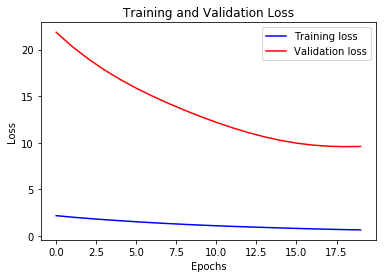

In [289]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")

### Predict/Actual (26th item = 2014 yr)

In [316]:
pred_y = model.predict(x)[0][0]*corn_std+corn_mean
actu_y = y[0].numpy()[0]*corn_std+corn_mean
targ_y = df[date_time_key][train_split+5]
print('year=%d, actual=%f, predict=%f' % (targ_y, actu_y, pred_y))

year=2012, actual=97.855114, predict=83.380861


In [317]:
str(targ_y)+' '+str(actu_y)+' '+ str(pred_y)

'2012 97.85511359423475 83.38086089234507'

In [237]:
# save results
file = open('record.txt', 'w') 
results = str(targ_y)+' '+str(actu_y)+' '+ str(pred_y)
file.write('results\n')
file.close()

In [314]:
def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 3) * 2]) #(future + 15) * 2
    plt.xlabel("Time-Step")
    plt.show()
    #print('MAE')
    #evaluate_naive_method(y[0].numpy()[0], model.predict(x)[0][0])
    return

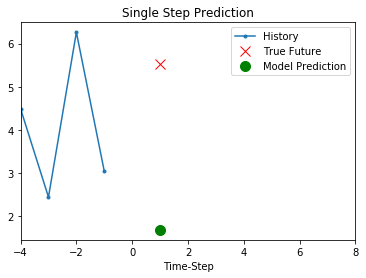

In [318]:
for x, y in dataset_val.take(2):
    show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), model.predict(x)[0]], 1,
        "Single Step Prediction",
    )

## Validation Index

In [303]:
#steps = len(df1['corn_actual'][3:])
#targets = df1['corn_actual'][3:]
#preds = df1['pred'][3:]
#print('year=%d, actual=%f, predict=%f' % (targ_y, actu_y, pred_y))
def evaluate_naive_method(targets,preds):
    batch_maes = []
    batch_rmse = []
    for step in range(steps):
        mae = np.mean(np.abs(preds - targets))
        rmse = np.sqrt(np.mean((preds - targets)**2))
        batch_maes.append(mae)
        batch_rmse.append(rmse)
    print('MAE(Million Acres)=',np.mean(batch_maes))
    print('RMSE(Million Acres)=',np.mean(batch_rmse))

In [319]:
recod = pd.read_csv("record01.csv",index_col='year')
recod.head()

,actual,pred
year,,
2011,90.995090,80.641135
2012,97.855114,83.380861
2013,95.855530,99.206265
2014,90.904925,92.587757
2015,95.734134,93.905326


Text(0.5, 1.0, '2012-2016 Acres Prediction')

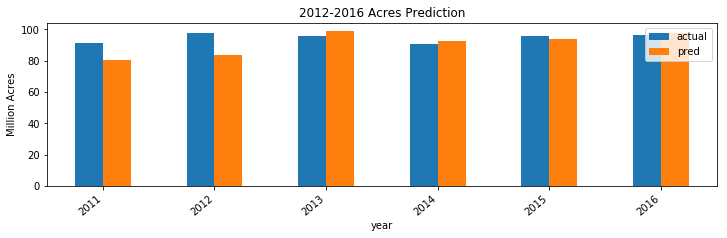

In [321]:
ax = recod.plot(kind='bar',figsize=(12,3)) 
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.set_ylabel("Million Acres")
ax.set_title("2012-2016 Acres Prediction")

In [320]:
#2011-2016
steps = len(recod)
targets = recod['actual']
preds = recod['pred']

evaluate_naive_method(targets,preds)

MAE(Million Acres)= 5.503121069999999
RMSE(Million Acres)= 7.481936308005062


In [323]:
#2013-2016
steps = len(recod.iloc[2:])
targets = recod.iloc[2:]['actual']
preds = recod.iloc[2:]['pred']

evaluate_naive_method(targets,preds)

MAE(Million Acres)= 2.047629707499997
RMSE(Million Acres)= 2.189055299361703


## Walk Forward Validation
### Expanding Window-way1

In [66]:
X = df.values
n_train = 25
n_records = len(X) #30
for i in range(n_train, n_records):
    train, test = X[0:i], X[i:i+1]
    print('train=%d, test=%d' % (len(train), len(test)))

train=25, test=1
train=26, test=1
train=27, test=1
train=28, test=1
train=29, test=1


In [67]:
from sklearn.model_selection import TimeSeriesSplit

In [72]:
tscv = TimeSeriesSplit(n_splits=15,max_train_size=28)
for train_index, test_index in tscv.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)

TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14] TEST: [15]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] TEST: [16]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16] TEST: [17]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17] TEST: [18]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18] TEST: [19]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] TEST: [20]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] TEST: [21]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21] TEST: [22]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22] TEST: [23]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [24]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24] TEST: [25]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25] TEST: [26]
TRAIN: [ 0  1  2  3 

### Question
1. if window size is 4 timesteps, ex:0,1,2,3->4,... 10,11,12,13->14, so if the test is only 15, we should use 11,12,13,14. if so, the validation data set is overlap with training data set?

In [ ]:
X_train, X_test = X[train_index], X[test_index]
y_train, y_test = y[train_index], y[test_index]